In [ ]:
!sudo apt -y install libportaudio2
!pip install -q tflite-model-maker

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libportaudio2 is already the newest version (19.6.0-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import pandas as pd
import cv2
import pathlib
import pickle
import tensorflow as tf
import tensorflow.keras.layers as tfl
import tflite_model_maker
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)
from PIL import Image
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tflite_model_maker import model_spec
from tflite_model_maker import image_classifier
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.image_classifier import DataLoader

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.listdir('/content/drive/MyDrive/cifar-100-python')

['train', 'test', 'file.txt~', 'meta', '.~lock.train#']

In [ ]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
path = '/content/drive/MyDrive/cifar-100-python/train'

train_dict = unpickle(path)

train_dict.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

In [ ]:
path = '/content/drive/MyDrive/cifar-100-python/meta'

names_dict = unpickle(path)

names_dict.keys()

dict_keys([b'fine_label_names', b'coarse_label_names'])

In [ ]:
fine_labels_list = train_dict[b'fine_labels']
coarse_labels_list = train_dict[b'coarse_labels']

fine_label_names_list = names_dict[b'fine_label_names']
coarse_label_names_list = names_dict[b'coarse_label_names']

print(len(fine_labels_list))
print(len(coarse_labels_list))
print(len(fine_label_names_list))
print(len(coarse_label_names_list))

50000
50000
100
20


In [ ]:
# Create the df_train dataframe
df_train = pd.DataFrame(fine_labels_list, columns=['fine_labels'])

# Create new columns
df_train['coarse_labels'] = coarse_labels_list
df_train['image_num'] = df_train.index + 100000

# Create the image_id column
def create_imageid(row):
    
    image_id = str(row['fine_labels']) + '_' + str(row['coarse_labels']) + '_' + str(row['image_num']) +'.jpg'
    
    return image_id

df_train['image_id'] = df_train.apply(create_imageid, axis=1)


# Create the fine and coarse label names columns

def create_finelabelname(x):
    
    # this returns bytes: b'apple'
    name = fine_label_names_list[x]
    
    # convert bytes to string: 'apple'
    name = name.decode("utf-8") 
    
    return name


def create_coarselabelname(x):
    
    # this returns bytes: b'apple'
    name = coarse_label_names_list[x]
    
    # convert bytes to string: 'apple'
    name = name.decode("utf-8") 
    
    return name


df_train['fine_label_names'] = df_train['fine_labels'].apply(create_finelabelname)

df_train['coarse_label_names'] = df_train['coarse_labels'].apply(create_coarselabelname)


# Remove unnecessary columns
df_train = df_train.drop('image_num', axis=1)

# Reorder the columns
cols = ['image_id', 'fine_label_names', 'fine_labels', 'coarse_label_names', 'coarse_labels']
df_train = df_train[cols]

df_train.head()

,image_id,fine_label_names,fine_labels,coarse_label_names,coarse_labels
0,19_11_100000.jpg,cattle,19,large_omnivores_and_herbivores,11
1,29_15_100001.jpg,dinosaur,29,reptiles,15
2,0_4_100002.jpg,apple,0,fruit_and_vegetables,4
3,11_14_100003.jpg,boy,11,people,14
4,1_1_100004.jpg,aquarium_fish,1,fish,1


In [ ]:
path = '/content/drive/MyDrive/cifar-100-python/test'

test_dict = unpickle(path)

test_dict.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

In [ ]:
fine_labels_list = test_dict[b'fine_labels']
coarse_labels_list = test_dict[b'coarse_labels']

fine_label_names_list = names_dict[b'fine_label_names']
coarse_label_names_list = names_dict[b'coarse_label_names']

print(len(fine_labels_list))
print(len(coarse_labels_list))
print(len(fine_label_names_list))
print(len(coarse_label_names_list))

10000
10000
100
20


In [ ]:
# Create the df_test dataframe
df_test = pd.DataFrame(fine_labels_list, columns=['fine_labels'])

# Create new columns
df_test['coarse_labels'] = coarse_labels_list
df_test['image_num'] = df_test.index + 200000

# Create the image_id column
def create_imageid(row):
    
    image_id = str(row['fine_labels']) + '_' + str(row['coarse_labels']) + '_' + str(row['image_num']) +'.jpg'
    
    return image_id

df_test['image_id'] = df_test.apply(create_imageid, axis=1)


# Create the fine and coarse label names columns

def create_finelabelname(x):
    
    # this returns bytes: b'apple'
    name = fine_label_names_list[x]
    
    # convert bytes to string: 'apple'
    name = name.decode("utf-8") 
    
    return name


def create_coarselabelname(x):
    
    # this returns bytes: b'apple'
    name = coarse_label_names_list[x]
    
    # convert bytes to string: 'apple'
    name = name.decode("utf-8") 
    
    return name


df_test['fine_label_names'] = df_test['fine_labels'].apply(create_finelabelname)

df_test['coarse_label_names'] = df_test['coarse_labels'].apply(create_coarselabelname)


# Remove unnecessary columns
df_test = df_test.drop('image_num', axis=1)

# Reorder the columns
cols = ['image_id', 'fine_label_names', 'fine_labels', 'coarse_label_names', 'coarse_labels']
df_test = df_test[cols]

df_test.head()

,image_id,fine_label_names,fine_labels,coarse_label_names,coarse_labels
0,49_10_200000.jpg,mountain,49,large_natural_outdoor_scenes,10
1,33_10_200001.jpg,forest,33,large_natural_outdoor_scenes,10
2,72_0_200002.jpg,seal,72,aquatic_mammals,0
3,51_4_200003.jpg,mushroom,51,fruit_and_vegetables,4
4,71_10_200004.jpg,sea,71,large_natural_outdoor_scenes,10


In [ ]:
df_train.to_csv('train.csv', index=False)
df_test.to_csv('test.csv', index=False)

In [ ]:
train_csv = pd.read_csv('/content/train.csv')
test_csv = pd.read_csv('/content/test.csv')

train_data = pd.DataFrame(train_csv)
test_data =  pd.DataFrame(test_csv)

In [ ]:
path_train = '/content/drive/MyDrive/cifar-100-python/train'

train_dict = unpickle(path_train)
train_matrix = train_dict[b'data']

path_test = '/content/drive/MyDrive/cifar-100-python/test'

test_dict = unpickle(path_test)
test_matrix = test_dict[b'data']

In [ ]:
print(test_matrix.shape)
train_data.head()

(10000, 3072)


,image_id,fine_label_names,fine_labels,coarse_label_names,coarse_labels
0,19_11_100000.jpg,cattle,19,large_omnivores_and_herbivores,11
1,29_15_100001.jpg,dinosaur,29,reptiles,15
2,0_4_100002.jpg,apple,0,fruit_and_vegetables,4
3,11_14_100003.jpg,boy,11,people,14
4,1_1_100004.jpg,aquarium_fish,1,fish,1


In [ ]:
# Create people directory
if os.path.isdir('1') == True:
  dir = '/content/1'
  for f in os.listdir(dir):
      os.remove(os.path.join(dir, f))

if os.path.isdir('1') == False:
    train_images = '1'
    os.mkdir(train_images)


# Create not_people directory
if os.path.isdir('0') == True:
  dir = '/content/0'
  for f in os.listdir(dir):
      os.remove(os.path.join(dir, f))

else:
    train_images = '0'
    os.mkdir(train_images)

In [ ]:
#Combined dataframe of both test and train
combined_data = train_data.append(test_data)
combined_matrix = np.append(train_matrix,test_matrix)

In [ ]:
random = combined_data[(combined_data['fine_labels']==0)].sample(31,replace=False)        # Initialize random dataframe
# select 31 random images from each class(fine label)
for i in range(1,100):
  label_index = combined_data[(combined_data['fine_labels']==i)].sample(31,replace=False)
  random = random.append(label_index)

In [ ]:
# People dataframe from combined
people_data = combined_data[(combined_data['coarse_label_names']=='people')]

# Randomize people dataframe
people = people_data.sample(frac=1)
people.head()

,image_id,fine_label_names,fine_labels,coarse_label_names,coarse_labels
38925,11_14_138925.jpg,boy,11,people,14
46703,11_14_146703.jpg,boy,11,people,14
31348,98_14_131348.jpg,woman,98,people,14
11825,98_14_111825.jpg,woman,98,people,14
32137,2_14_132137.jpg,baby,2,people,14


In [ ]:
# Remove all the people elements 
not_people = random[random.coarse_label_names != 'people']

# add 55 random elements from not people to make 3000 images (equal to people)
not_people = not_people.append(not_people.sample(n=55))

#Randomize not_people
not_people = not_people.sample(frac=1)

#Convert and store not_people dataframe to csv
# not_people.to_csv('not_people.csv')
print(len(not_people))
not_people.head()

3000


,image_id,fine_label_names,fine_labels,coarse_label_names,coarse_labels
22117,60_10_122117.jpg,plain,60,large_natural_outdoor_scenes,10
36054,13_18_136054.jpg,bus,13,vehicles_1,18
20076,96_17_120076.jpg,willow_tree,96,trees,17
43444,26_13_143444.jpg,crab,26,non-insect_invertebrates,13
4760,90_18_104760.jpg,train,90,vehicles_1,18


In [ ]:
count = 0
print(len(people))

3000


In [ ]:
# Prepare train images
for i in range(0, train_matrix.shape[0]):
    if(train_data.loc[i,'image_id'] in people.values):
      
      # Get the image_id from the df_train dataframe
      image_id = train_data.loc[i, 'image_id']


      # Select an image
      row = train_matrix[i]

      # Extract each channel
      ch0 = row[0:1024] 
      ch1 = row[1024:2048]
      ch2 = row[2048:]

      # Reshape to 32x32
      ch0 = np.reshape(ch0, (32,32)) # red
      ch1 = np.reshape(ch1, (32,32)) # green
      ch2 = np.reshape(ch2, (32,32)) # blue

      # Stack the matrices along the channel axis
      image = np.dstack((ch0, ch1, ch2))

      
      # Save the image in the folder
      # that we created.
      fname = image_id
      dst = os.path.join('1', fname)
      
      # If cv2.COLOR_RGB2BGR is not used then the saved images appear blue.
      cv2.imwrite(dst, image)
      count = count + 1

# Not-People
    if(train_data.loc[i,'image_id'] in not_people.values):
      # Get the image_id from the df_train dataframe
      image_id = train_data.loc[i, 'image_id']


      # Select an image
      row = train_matrix[i]

      # Extract each channel
      ch0 = row[0:1024] 
      ch1 = row[1024:2048]
      ch2 = row[2048:]

      # Reshape to 32x32
      ch0 = np.reshape(ch0, (32,32)) # red
      ch1 = np.reshape(ch1, (32,32)) # green
      ch2 = np.reshape(ch2, (32,32)) # blue

      # Stack the matrices along the channel axis
      image = np.dstack((ch0, ch1, ch2))

      
      # Save the image in the folder
      # that we created.
      fname = image_id
      dst = os.path.join('0', fname)
      
      # If cv2.COLOR_RGB2BGR is not used then the saved images appear blue.
      cv2.imwrite(dst, image)
      count = count + 1

In [ ]:
# Prepare test images
for i in range(0, test_matrix.shape[0]):
    if(test_data.loc[i,'image_id'] in people.values):
      
      # Get the image_id from the df_train dataframe
      image_id = test_data.loc[i, 'image_id']


      # Select an image
      row = test_matrix[i]

      # Extract each channel
      ch0 = row[0:1024] 
      ch1 = row[1024:2048]
      ch2 = row[2048:]

      # Reshape to 32x32
      ch0 = np.reshape(ch0, (32,32)) # red
      ch1 = np.reshape(ch1, (32,32)) # green
      ch2 = np.reshape(ch2, (32,32)) # blue

      # Stack the matrices along the channel axis
      image = np.dstack((ch0, ch1, ch2))

      
      # Save the image in the folder
      # that we created.
      fname = image_id
      dst = os.path.join('1', fname)
      
      # If cv2.COLOR_RGB2BGR is not used then the saved images appear blue.
      cv2.imwrite(dst, image)
      count = count + 1

# Not-People
    if(test_data.loc[i,'image_id'] in not_people.values):
      # Get the image_id from the df_train dataframe
      image_id = test_data.loc[i, 'image_id']


      # Select an image
      row = test_matrix[i]

      # Extract each channel
      ch0 = row[0:1024] 
      ch1 = row[1024:2048]
      ch2 = row[2048:]

      # Reshape to 32x32
      ch0 = np.reshape(ch0, (32,32)) # red
      ch1 = np.reshape(ch1, (32,32)) # green
      ch2 = np.reshape(ch2, (32,32)) # blue

      # Stack the matrices along the channel axis
      image = np.dstack((ch0, ch1, ch2))

      
      # Save the image in the folder
      # that we created.
      fname = image_id
      dst = os.path.join('0', fname)
      
      # If cv2.COLOR_RGB2BGR is not used then the saved images appear blue.
      cv2.imwrite(dst, image)
      count = count + 1

In [ ]:
# dir = '/content/dataset/1'
# for f in os.listdir(dir):
#       os.remove(os.path.join(dir, f))

In [ ]:
os.mkdir('dataset')
shutil.move('/content/0','dataset/')
shutil.move('/content/1','dataset/')

'dataset/1'

In [ ]:
# Convert and store people dataframe to csv
# people.to_csv('people.csv')

In [ ]:
# !zip -r /content/people.zip /content/people_images
# from google.colab import files
# files.download("/content/people.zip")

# !zip -r /content/not_people.zip /content/not_people_images
# from google.colab import files
# files.download("/content/not_people.zip")

In [ ]:
count

5945

In [ ]:
data = DataLoader.from_folder('/content/dataset')

INFO:tensorflow:Load image with size: 5945, num_label: 2, labels: 0, 1.


In [ ]:
train_data, test_data = data.split(0.8)

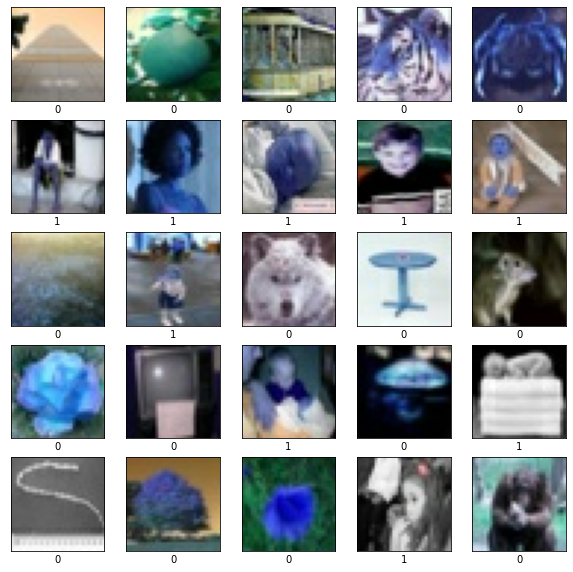

In [ ]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(data.gen_dataset().unbatch().take(25)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  plt.xlabel(data.index_to_label[label.numpy()])
plt.show()

In [ ]:
tflite_model_maker.image_classifier.EfficientNetLite0Spec(
    uri='https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2',
    compat_tf_versions=[1, 2],
    input_image_shape=[32,32],
    name='efficientnet_lite0'
)

# tflite_model_maker.image_classifier.EfficientNetLite1Spec(
#     uri='https://tfhub.dev/tensorflow/efficientnet/lite1/feature-vector/2',
#     compat_tf_versions=[1, 2],
#     input_image_shape=None,
#     name='efficientnet_lite1'
# )

# tflite_model_maker.image_classifier.EfficientNetLite2Spec(
#     uri='https://tfhub.dev/tensorflow/efficientnet/lite2/feature-vector/2',
#     compat_tf_versions=[1, 2],
#     input_image_shape=[260, 260],
#     name='efficientnet_lite2'
# )

# tflite_model_maker.image_classifier.EfficientNetLite3Spec(
#     uri='https://tfhub.dev/tensorflow/efficientnet/lite3/feature-vector/2',
#     compat_tf_versions=[1, 2],
#     input_image_shape=[280, 280],
#     name='efficientnet_lite3'
# )

# tflite_model_maker.image_classifier.EfficientNetLite4Spec(
#     uri='https://tfhub.dev/tensorflow/efficientnet/lite4/feature-vector/2',
#     compat_tf_versions=[1, 2],
#     input_image_shape=[300, 300],
#     name='efficientnet_lite4'
# )

# tflite_model_maker.image_classifier.MobileNetV2Spec(
#     uri='https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4',
#     compat_tf_versions=2,
#     input_image_shape=None,
#     name='mobilenet_v2'
# )

In [ ]:
model = tflite_model_maker.image_classifier.create(
    train_data,
    model_spec='efficientnet_lite0',
    validation_data=test_data,
    batch_size=32,
    epochs=10,
    steps_per_epoch=None,
    train_whole_model=None,
    dropout_rate=0.2,
    learning_rate=0.001,
    momentum=None,
    shuffle=False,
    use_augmentation=True,
    use_hub_library=True,
    warmup_steps=None,
    model_dir=None,
    do_train=True
)

INFO:tensorflow:Retraining the models...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2 (HubKe  (None, 1280)             3413024   
 rasLayerV1V2)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 3,415,586
Trainable params: 2,562
Non-trainable params: 3,413,024
_________________________________________________________________
None


INFO:tensorflow:Use default resize_bicubic.
INFO:tensorflow:Use customized resize method bilinear
INFO:tensorflow:Use customized resize method bilinear


Epoch 1/10
148/148 [==============================] - 27s 98ms/step - loss: 0.5900 - accuracy: 0.7031 - val_loss: 0.4398 - val_accuracy: 0.8427
Epoch 2/10
148/148 [==============================] - 16s 105ms/step - loss: 0.5187 - accuracy: 0.7720 - val_loss: 0.4103 - val_accuracy: 0.8705
Epoch 3/10
148/148 [==============================] - 15s 104ms/step - loss: 0.4911 - accuracy: 0.8009 - val_loss: 0.3989 - val_accuracy: 0.8789
Epoch 4/10
148/148 [==============================] - 14s 92ms/step - loss: 0.4866 - accuracy: 0.8015 - val_loss: 0.3916 - val_accuracy: 0.8780
Epoch 5/10
148/148 [==============================] - 14s 92ms/step - loss: 0.4808 - accuracy: 0.8106 - val_loss: 0.3875 - val_accuracy: 0.8747
Epoch 6/10
148/148 [==============================] - 14s 92ms/step - loss: 0.4771 - accuracy: 0.8106 - val_loss: 0.3862 - val_accuracy: 0.8823
Epoch 7/10
148/148 [==============================] - 14s 93ms/step - loss: 0.4755 - accuracy: 0.8095 - val_loss: 0.3805 - val_accurac

In [ ]:
# model.summary()

In [ ]:
loss, accuracy = model.evaluate(test_data)

INFO:tensorflow:Use customized resize method bilinear


38/38 [==============================] - 4s 67ms/step - loss: 0.3748 - accuracy: 0.8881


In [ ]:
# # A helper function that returns 'red'/'black' depending on if its two input

# # parameter matches or not.
# def get_label_color(val1, val2):
#   if val1 == val2:
#     return 'black'
#   else:
#     return 'red'

# # Then plot 100 test images and their predicted labels.
# # If a prediction result is different from the label provided label in "test"
# # dataset, we will highlight it in red color.
# plt.figure(figsize=(20, 20))
# predicts = model.predict_top_k(test_data)
# for i, (image, label) in enumerate(test_data.gen_dataset().unbatch().take(100)):
#   ax = plt.subplot(10, 10, i+1)
#   plt.xticks([])
#   plt.yticks([])
#   plt.grid(False)
#   plt.imshow(image.numpy(), cmap=plt.cm.gray)

#   predict_label = predicts[i][0][0]
#   color = get_label_color(predict_label,
#                           test_data.index_to_label[label.numpy()])
#   ax.xaxis.label.set_color(color)
#   plt.xlabel('Predicted: %s' % predict_label)
# plt.show()

In [ ]:
model.export(export_dir='.', export_format=ExportFormat.SAVED_MODEL)

INFO:tensorflow:Assets written to: ./saved_model/assets


In [ ]:
# saved_model_dir = '/content/saved_model'
# converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_types = [tf.float16]
# tflite_fp16_model = converter.convert()
# tflite_model_fp16_file = tflite_models_dir/"model_quant_f16.tflite"
# tflite_model_fp16_file.write_bytes(tflite_fp16_model)

In [ ]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [91.7 kB]
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,540 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]


In [ ]:

model.export(export_dir='.', export_format=ExportFormat.SAVED_MODEL)
tflite_models_dir = pathlib.Path("/content/")    
converter = tf.lite.TFLiteConverter.from_saved_model('/content/saved_model')

INFO:tensorflow:Assets written to: ./saved_model/assets


In [ ]:
tflite_model = converter.convert()
tflite_model_file = tflite_models_dir/"effnet_model.tflite"
tflite_model_file.write_bytes(tflite_model)

13448816

In [ ]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

In [ ]:
tflite_fp16_model = converter.convert()
tflite_model_fp16_file = tflite_models_dir/"effnet_model_quant_f16.tflite"
tflite_model_fp16_file.write_bytes(tflite_fp16_model)

6762276

In [ ]:
MODELS_DIR = '/content/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
# MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE = MODELS_DIR + 'effnet_model_quant_f16.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

In [ ]:
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}